## **Cosmological Parameter inference from convergence ($\kappa$) maps using BNNs.**

In this notebook we train a BNN to predict cosmological parameter constraints  ($\Omega_m$-$\sigma_8$) from weak lensing convergence mass maps.

Then we save:

 i) The model weights so further exploration (predictions on test set examples) can be done without having to retrain the model.

 ii) The predicted posterior distributions (samples) for a test set of 1000 maps, to be passed in a different notebook for calibration plot creation, comparison with NPE etc.

In [2]:
# First install the packages below. It will be good to restart the runtime after installing.

#!apt-get update
#!sudo apt-get install texlive-latex-recommended 
#!sudo apt install texlive-latex-extra
#!sudo apt install dvipng
#!apt install cm-super
#!pip install chainconsumer

In [3]:
# Import basic packages
import numpy as np
import scipy as sp
import pandas as pd


# Colab in order to download files
from google.colab import files

# Scikit-learn for scaling and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Chainconsumer
from chainconsumer import ChainConsumer

# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

# Pillow
from PIL import Image

**Import TensorFlow, TensorFlow Probability, Keras**

In [4]:
# Tensorflow and Keras
import tensorflow as tf
import tensorflow_probability as tfp


from tensorflow import keras 
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
# Keras Layers
from keras.layers import InputLayer
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

# Import some layers etc that are useful in the Functional approach
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LeakyReLU

In [5]:
# Garbage collector to free up memory
import gc

### **Import Dataset**

In [6]:
# Mount drive to upload the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Paths to the folders where we have saved the data, the images, and the trained models

# DATASETS
DATA_PATH = '/content/drive/My Drive/Maps_Project/Deliverables_Maps/Datasets/'

# PLOTS
PLT_PATH = '/content/drive/My Drive/Maps_Project/Deliverables_Maps/Plots/'

# SAVED MODELS
MODELS_PATH = '/content/drive/My Drive/Maps_Project/Deliverables_Maps/Saved_Models/'

In [8]:
# LOAD MAPS - Change to the dataset you actually want to load

# X_maps = np.float64(np.load(DATA_PATH+"X_maps_Cosmogrid_100k",mmap_mode='r')) #Cosmogrid, 100k randomly shuffled, without noise 
X_maps = np.float64(np.load(DATA_PATH+"X_maps_Cosmogrid_100k_NOISY.npy",mmap_mode='r')) #Cosmogrid, 100k randomly shuffled, with noise
# =============================================================
# =============================================================
# LOAD LABELS - Change to the dataset you actually want to load 
y_cosmo = np.float64(np.load(DATA_PATH+"y_maps_Cosmogrid_100k.npy")) # These labels are common for noisy and without noise cosmogrid sims

**Print the shape of the data**

In [9]:
print("Shape of maps dataset:", np.shape(X_maps))
print("Shape of cosmological parameters vector:", np.shape(y_cosmo))

Shape of maps dataset: (100000, 66, 66)
Shape of cosmological parameters vector: (100000, 6)


### **Split into training, validation, and test sets**

If the full dataset is randomized, we can simply slice the full dataset.



In [10]:
# Keep a number of maps for training, validation, and testing
X_train = X_maps[:80000]
X_val = X_maps[80000:90000]
X_test = X_maps[90000:]

# Delete the full, large dataset to free memory
del X_maps

For **Cosmogrid**, the order of cosmological parameters is:  $\Omega_m$, $H_0$, $n_s$, $\sigma_8$, $w_0$.

Keep just $\Omega_m, \sigma_8$ here.  

In [11]:
# Keep just Omega_m and sigma_8
y_Omega = y_cosmo[:,0];y_sigma_8 = y_cosmo[:,3]

# Labels for two cosmological parameters 
y_cosmo_2 = np.stack([y_Omega,y_sigma_8],axis=-1)

# Split into training, validation, test sets
y_train  = y_cosmo_2[:80000]
y_val = y_cosmo_2[80000:90000]
y_test = y_cosmo_2[90000:]

# Delete what we do not need any more
del y_cosmo_2, y_cosmo, y_Omega, y_sigma_8

### Label preprocessing and standardization

Since the labels span different ranges, here we perform a min-max scaling
to bring them to a similar range.

In [12]:
# Define the scaler
scaler = MinMaxScaler()

# Fit the scaler 
scaler.fit(y_train)

# Rescale
y_train_sc = scaler.transform(y_train)
y_val_sc = scaler.transform(y_val)
y_test_sc = scaler.transform(y_test)

### **Define the Bayesian Neural Network (BNN)**

In [13]:
# Define basic numbers
IMAGE_SHAPE = [66,66,1] # This may change
NUM_TRAIN_EXAMPLES = 80000
NUM_VAL_EXAMPLES = 10000
NUM_TEST_EXAMPLES = 10000
NUM_CLASSES = 2

In [14]:
# Define KL divergence
tfd = tfp.distributions

# KL divergence weighted by the number of training samples, using
# lambda function to pass as input to the kernel_divergence_fn on
# flipout layers.
kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                           tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))

In [15]:
#Clears session when running this cell
tf.keras.backend.clear_session()

# Alpha for LeakyRelu
al_rel = 0.05
reg_str = 0.0001 #Apply a regularization


# Bayesian model in functional form

# Model input - **CHANGE INPUT SHAPE IF USING DIFFERENT DATASET**
model_input = Input(shape=(66,66,1))


# Convolutional part =================
# 1st convolutional chunk 
x = tfp.layers.Convolution2DFlipout(
          filters = 12, 
          kernel_size=(4,4),
          padding='valid',
          kernel_divergence_fn=kl_divergence_function)(model_input)
x = LeakyReLU(alpha=al_rel)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)


# 2nd convolutional chunk 
x = tfp.layers.Convolution2DFlipout(
          filters = 2*12, 
          kernel_size=(4,4),
          padding='valid',
          kernel_divergence_fn=kl_divergence_function)(model_input)
x = LeakyReLU(alpha=al_rel)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)

# 3rd convolutional chunk 
x = tfp.layers.Convolution2DFlipout(
          filters = 4*12, 
          kernel_size=(3,3),
          padding='valid',
          kernel_divergence_fn=kl_divergence_function)(model_input)
x = LeakyReLU(alpha=al_rel)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)

# =========================================
x = keras.layers.Flatten()(x)
# =========================================
# =========================================

x = tfp.layers.DenseFlipout(units = 128, 
          kernel_divergence_fn=kl_divergence_function)(x)
x = keras.layers.LeakyReLU(alpha=al_rel)(x)
x = tfp.layers.DenseFlipout(units = 64, 
          kernel_divergence_fn=kl_divergence_function)(x)
x = keras.layers.LeakyReLU(alpha=al_rel)(x)
x = tfp.layers.DenseFlipout(units = 32,
          kernel_divergence_fn=kl_divergence_function)(x)
x = keras.layers.LeakyReLU(alpha=al_rel)(x)


distribution_params = keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(2))(x)
model_output = tfp.layers.MultivariateNormalTriL(event_size=2)(distribution_params)
model = Model(model_input, model_output)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [16]:
# Define the optimizer 
optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.1,rho=0.9,epsilon=1e-07)

# Define loss
def negloglik(y_true, y_pred):    
    return -tf.reduce_mean(y_pred.log_prob(y_true))


# Compile the model
model.compile(optimizer,
              loss=negloglik,
              metrics=['mae'],experimental_run_tf_function=False)

**Train the model**

In [17]:
EPOCHS = 160

model.fit(x=X_train, y=y_train_sc,
          epochs=EPOCHS,
          batch_size=128,
          shuffle=True,
          validation_data=(X_val,y_val_sc))

Epoch 1/160
625/625 [==============================] - 39s 41ms/step - loss: 200.3854 - mae: 0.4494 - val_loss: 199.4910 - val_mae: 0.3400
Epoch 2/160
625/625 [==============================] - 21s 33ms/step - loss: 199.3128 - mae: 0.3234 - val_loss: 199.2266 - val_mae: 0.3125
Epoch 3/160
625/625 [==============================] - 21s 33ms/step - loss: 199.1555 - mae: 0.3103 - val_loss: 199.0959 - val_mae: 0.3063
Epoch 4/160
625/625 [==============================] - 21s 34ms/step - loss: 199.0468 - mae: 0.3047 - val_loss: 198.9996 - val_mae: 0.3015
Epoch 5/160
625/625 [==============================] - 21s 33ms/step - loss: 198.9386 - mae: 0.3020 - val_loss: 198.8816 - val_mae: 0.3013
Epoch 6/160
625/625 [==============================] - 21s 33ms/step - loss: 198.8114 - mae: 0.2972 - val_loss: 198.7198 - val_mae: 0.2947
Epoch 7/160
625/625 [==============================] - 21s 33ms/step - loss: 198.6312 - mae: 0.2924 - val_loss: 198.5091 - val_mae: 0.2921
Epoch 8/160
625/625 [======

In [18]:
# Save the weights of the trained model 

# model.save_weights(MODELS_PATH+'BNN_network__COSMOGRID_weights.h5',overwrite=True) 
model.save_weights(MODELS_PATH+'BNN_network__COSMOGRID_weights_NOISY.h5',overwrite=True)

Make a plot of the training history.

In [19]:
history_dict = model.history.history

train_mae = history_dict['mae']
val_mae = history_dict['val_mae']

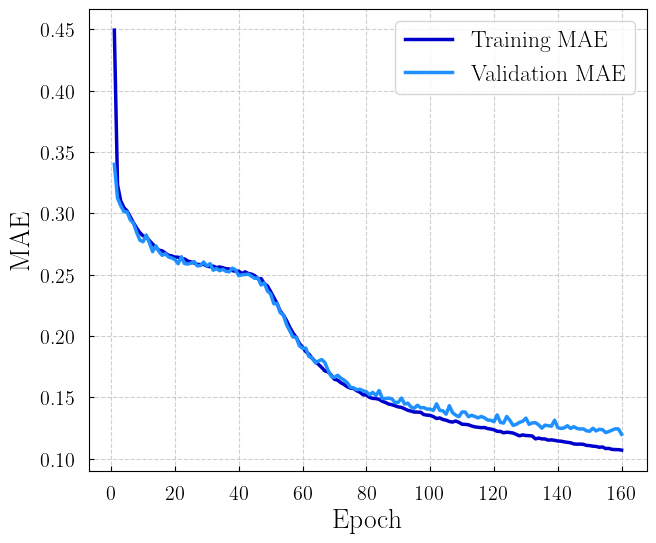

In [20]:
Epochs_sp = np.arange(1,EPOCHS+1,1)

# ==============================================================================
# ==============================================================================

plt.figure(figsize=(7.2, 6.0))

# Plot MAE
plt.plot(Epochs_sp, train_mae, c = 'mediumblue',linewidth=2.5,label='Training MAE')
plt.plot(Epochs_sp, val_mae, c = 'dodgerblue',linewidth=2.5,label='Validation MAE')

# ==========================================
# ==========================================
plt.grid(ls='--',alpha=0.6)
plt.xlabel('Epoch', fontsize=20);plt.ylabel('MAE',fontsize=20)
plt.legend(frameon=True, loc='upper right', fontsize=17)
plt.tick_params(axis='both', labelsize=14.5)

#plt.xlim(20,)
#plt.ylim(0.0,0.5)

# Save figure - change name
plt.savefig(PLT_PATH+"MAE_COSMOGRID_NOISY.pdf")
#plt.savefig(PLT_PATH+"MAE_COSMOGRID.pdf")
plt.show()

### Make predictions on a part of the test set

In [21]:
# Keep the first 1000 examples
n_test = 1000

X_keep = X_test[:n_test]
y_keep = y_test[:n_test]
y_keep_sc = y_test_sc[:n_test]

**This may take a few minutes to run:**

In [22]:
pred_dist = model(X_keep)
sample = np.asarray(pred_dist.sample(300))

#print(np.shape(sample))

n_rands = 100


for i in range(n_rands):
  print(i)
  pred_dist = model(X_keep)
  sample_loc = np.asarray(pred_dist.sample(300))
  sample = np.concatenate((sample,sample_loc))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Now these results are normalized, invert them to get the real cosmological parameters.

In [23]:
inv_sample = []

for i in range(n_test):
  inv_sample_loc = scaler.inverse_transform(sample[:,i,:])
  inv_sample.append(inv_sample_loc)

In [24]:
#np.save(MODELS_PATH+"samples_test_BNN.npy",inv_sample)
np.save(MODELS_PATH+"samples_test_BNN_NOISY.npy",inv_sample)